# Train Camera Parameters

In [16]:
from collections import namedtuple
from IPython.display import display

import numpy as np


import matplotlib.pyplot as plt

import torch
import source.tensorize as t
import torch.optim as optim 
import torch.nn.functional as F
from source.scene import *
from source.renderer import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Ground Truth and Initial Guess

Remember the trainable quantities are the scene parameters.  

In [34]:
experiment = 'camera_test_1'
true_scene = parse_scene('./scenes/%s.ground_truth.yaml' % experiment)
pred_scene = parse_scene('./scenes/%s.init1.yaml' % experiment)


Now create the images and display the initialization:

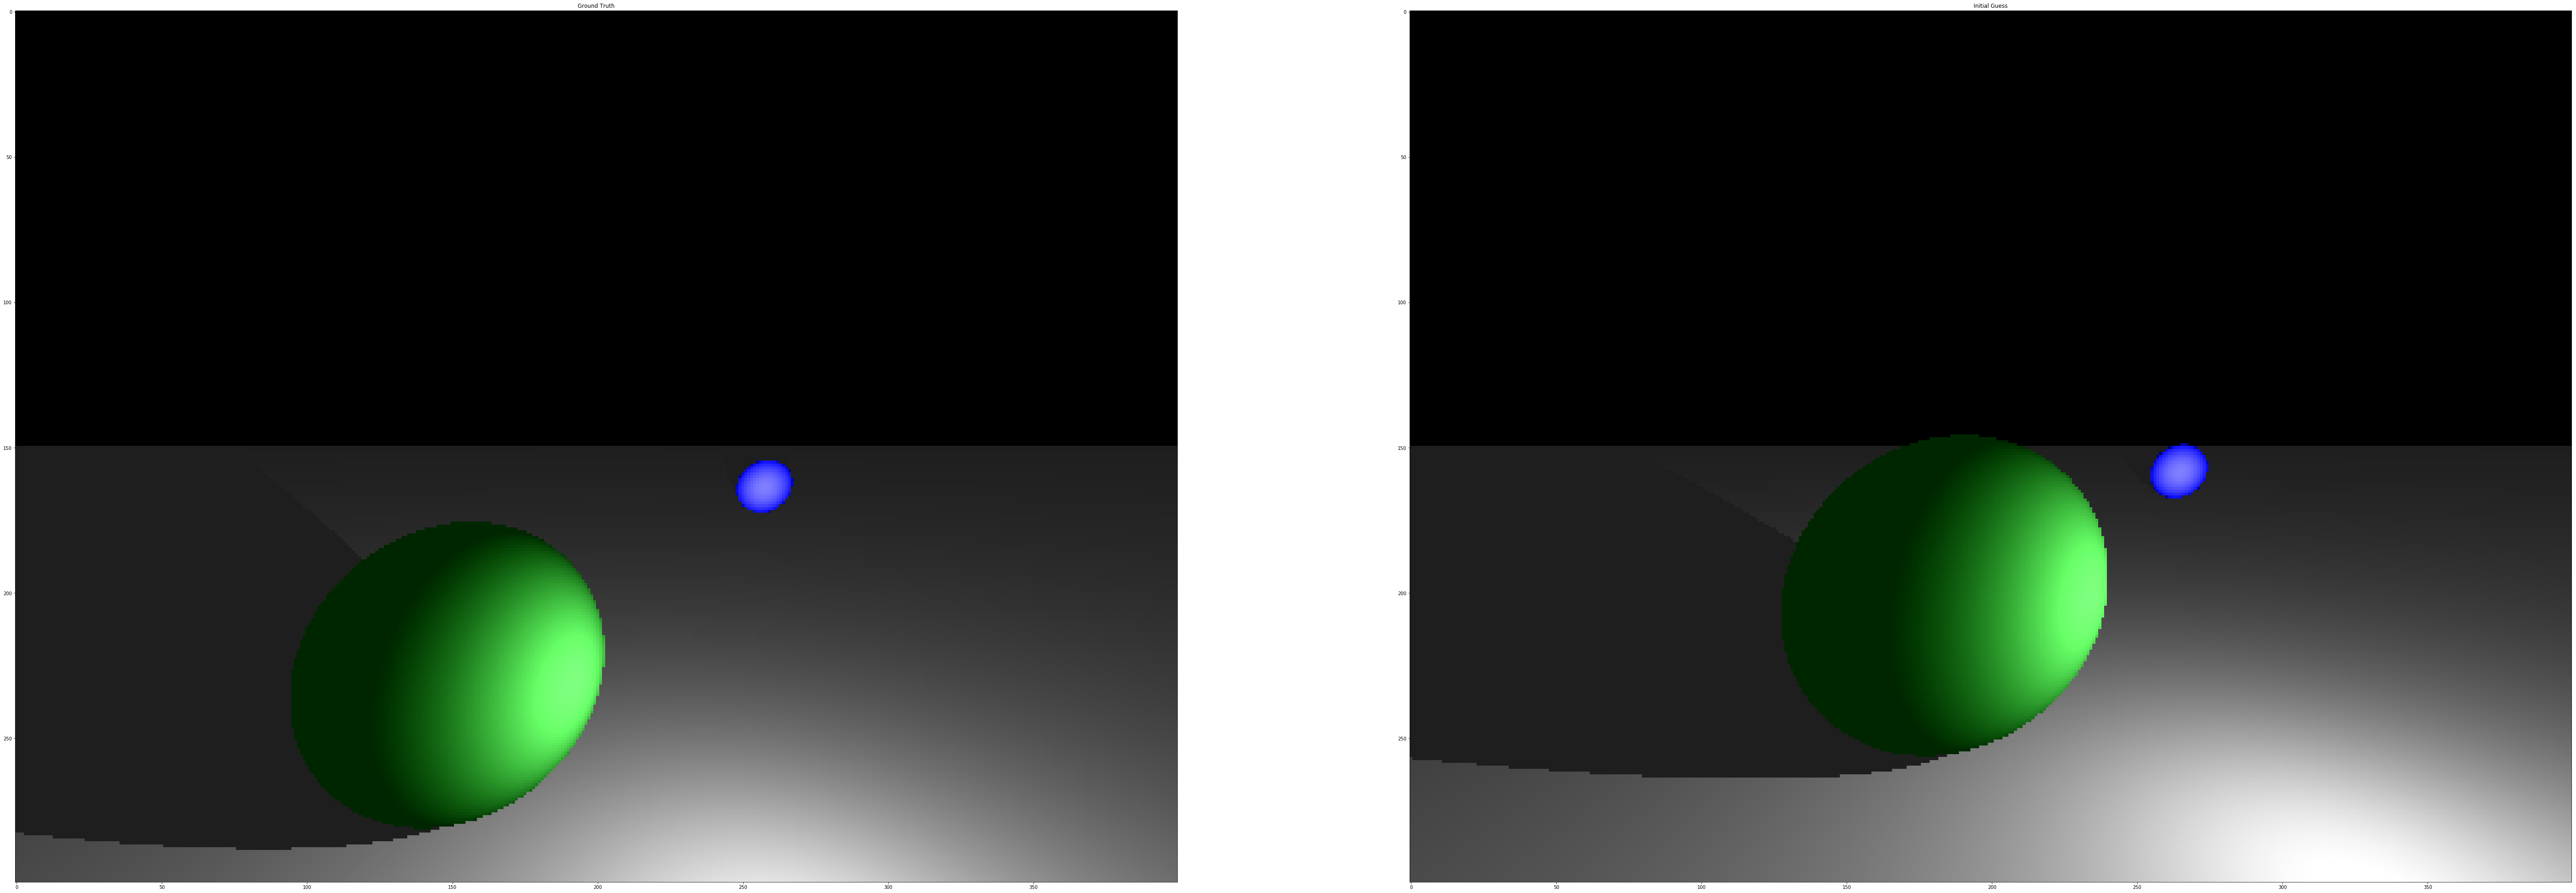

Ground Truth parameters: pos=[-1.5 -1.5 -4. ]
Initial guess parameters: pos=[-0.88033515 -0.93433106 -3.9927318 ]


In [42]:
plt.figure(figsize=(100,100))
true_renderer = PhongRenderer(true_scene)
true_image = true_renderer.forward()
true_image.show_image('albedo', title='Ground Truth', subplot='121')

pred_renderer = PhongRenderer(pred_scene)
pred_image = pred_renderer.forward()
pred_image.show_image('albedo', title='Initial Guess', subplot='122')
plt.show()
          
print("Ground Truth parameters: pos={0}".format(t.detach_numpy(true_renderer.camera['position'])))
print("Initial guess parameters: pos={0}".format(t.detach_numpy(pred_renderer.camera['position'])))

### Todo: A smart loss function for the camera parameters...

In [40]:
def train(ground_truth, renderer, subsampling=True, image_type='albedo', iterations=1000):
    loss_history = []
    renderer.set_trainable({'camera': ['position']})
    params  = list(filter(lambda p: p.requires_grad, renderer.parameters()))
    optimizer = optim.Adam(params, lr=0.001)
    for _ in range(iterations):

        pred_renderer.clear()
        optimizer.zero_grad()

        predicition = renderer.forward()
        loss = F.l1_loss(ground_truth.get_image(image_type), predicition.get_image(image_type))
        loss.backward()
        optimizer.step()


        #history of intermediate losses and images 
        loss_history.append(t.detach_numpy(loss))

        if _ % (iterations/10) == 0:
            true_pos = t.detach_numpy(true_renderer.camera['position'])
            pred_pos = t.detach_numpy(renderer.camera['position'])

            ground_truth.show_image(image_type,title='Ground Truth: pos=({0:.2f}, {1:.2f}, {2:.2f})'
                                  .format(true_pos[0], true_pos[1], true_pos[2]), subplot='121')
            predicition.show_image(image_type,title='Guess {0}: pos=({1:.2f}, {2:.2f}, {3:.2f})'
                                  .format(_, pred_pos[0], pred_pos[1], pred_pos[2]), subplot='122')
            plt.subplots_adjust(wspace=1.0)
            plt.show()


    _ = np.arange(iterations)
    plt.plot(_, loss_history, label='loss')
    plt.xticks(_)
    plt.legend()
    plt.show()


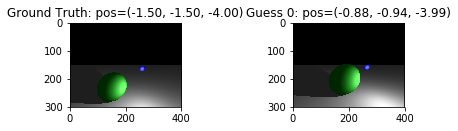

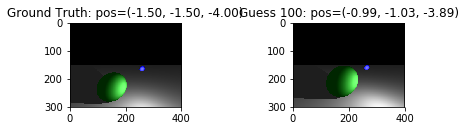

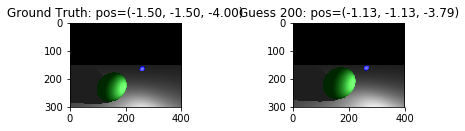

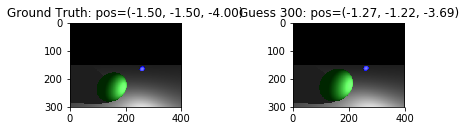

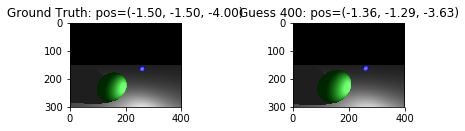

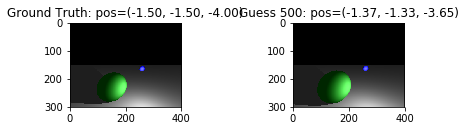

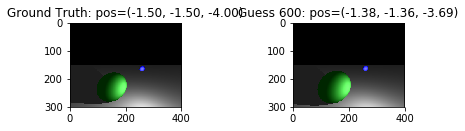

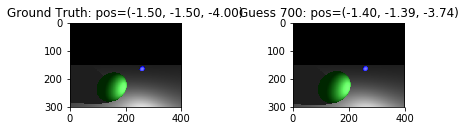

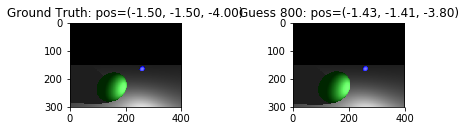

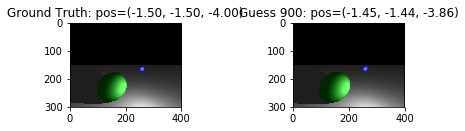

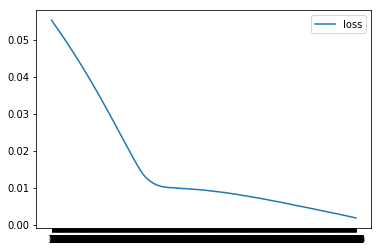

In [41]:
phong_renderer = PhongRenderer(pred_scene)
train(true_image, phong_renderer)

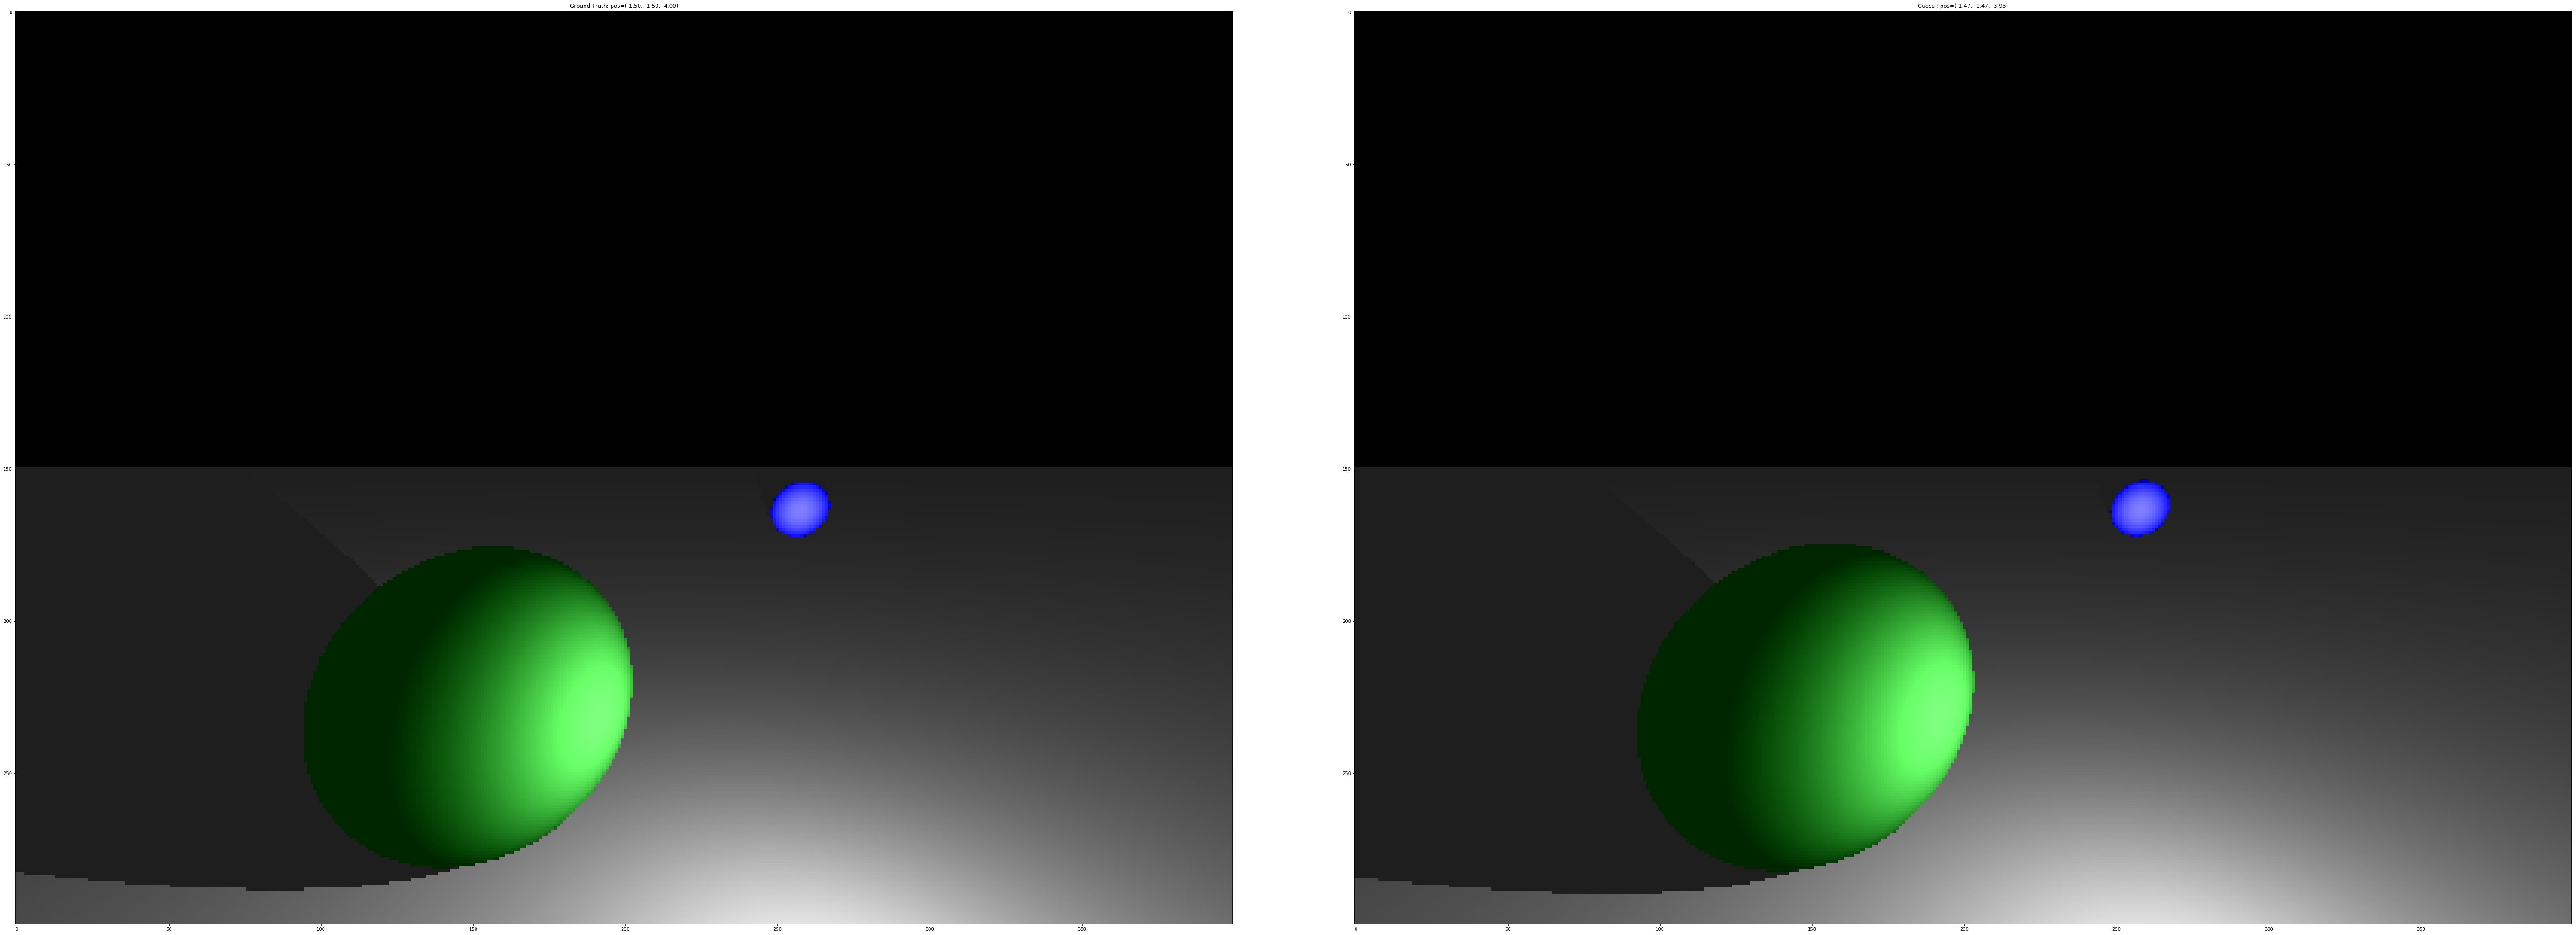

In [45]:
plt.figure(figsize=(100,100))
true_pos = t.detach_numpy(true_renderer.camera['position'])
pred_pos = t.detach_numpy(phong_renderer.camera['position'])

true_image.show_image('albedo',title='Ground Truth: pos=({0:.2f}, {1:.2f}, {2:.2f})'
                      .format(true_pos[0], true_pos[1], true_pos[2]), subplot='121')
phong_renderer.forward().show_image('albedo',title='Guess {0}: pos=({1:.2f}, {2:.2f}, {3:.2f})'
                      .format(_, pred_pos[0], pred_pos[1], pred_pos[2]), subplot='122')
plt.subplots_adjust(wspace=0.1)
plt.show()
